In [ ]:
# CNN WITH 1D DATA

In [ ]:
from __future__ import print_function
  
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input, Conv2D
from keras.layers.core import Flatten, Dense, Dropout,Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

import cv2
import numpy as np
import keras 
from keras.callbacks import ReduceLROnPlateau
from pyts.transformation import GASF, GADF, MTF, RecurrencePlots
from pyts.visualization import plot_ts,plot_gasf,plot_mtf,plot_recurrence_plots

import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
K.set_image_dim_ordering('th')

np.random.seed(813306)

In [ ]:
def VGG_16_new(weights_path=None):
    inputs = Input(shape=(3,224, 224))
    conv1 = Conv2D(64, (3, 3), activation='relu', name='conv1_1', padding='same', trainable = False)(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', name='conv1_2', padding='same', trainable = False)(conv1)
    pool1 = MaxPooling2D((2,2), strides=(2,2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', name='conv2_1', padding='same', trainable = False)(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', name='conv2_2', padding='same', trainable = False)(conv2)
    pool2 = MaxPooling2D((2,2), strides=(2,2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', name='conv3_1', padding='same', trainable = False)(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', name='conv3_2', padding='same', trainable = False)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', name='conv3_3', padding='same', trainable = False)(conv3)
    pool3 = MaxPooling2D((2,2), strides=(2,2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', name='conv4_1', padding='same', trainable = False)(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', name='conv4_2', padding='same', trainable = False)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', name='conv4_3', padding='same', trainable = False)(conv4)
    pool4 = MaxPooling2D((2,2), strides=(2,2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', name='conv5_1', padding='same', trainable = False)(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', name='conv5_2', padding='same', trainable = False)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', name='conv5_3', padding='same', trainable = False)(conv5)
    pool5 = MaxPooling2D((2,2), strides=(2,2))(conv4)
    
    pool5=Flatten()(pool5)
    
    dense_1 = Dense(4096,name='dense_1',activation='relu')(pool5)
    d1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(4096,name='dense_2',activation='relu')(d1)
    d2 = Dropout(0.5)(dense_2)

    dense_3 = Dense(1000,name='dense_3')(d2)
    prediction = Activation("softmax",name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    
    model.load_weights(weights_path, by_name=True)
    
    return model

 

In [3]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [10]:
def rebuildModel():

    model = VGG_16_new("D:\\dataset\\vgg16_weights.h5")
    # Test pretrained model

    #two optimizers for choice
    adam = keras.optimizers.Adam()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


    model.compile(optimizer=adam, loss='categorical_crossentropy')

    #Change the model.
    pop_layer(model)
    pop_layer(model)

    pop_layer(model)
    pop_layer(model)

    pop_layer(model)
    pop_layer(model)

    dense_1 = Dense(128,name='dense_1',activation='relu')(model.layers[-1].output)
    d1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(128,name='dense_2',activation='relu')(d1)
    d2 = Dropout(0.5)(dense_2)


    dense_3 = Dense(2,name='dense_3')(d1)
    prediction = Activation("softmax",name="softmax")(dense_3)

    model1 = Model(input=model.layers[0].input, output=prediction)


    model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model1



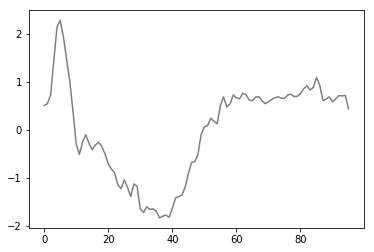

(100, 96) (100,) (100, 96) (100,)


In [11]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    #print(data[0:100])
    Y = data[:,0]
    X = data[:,1:]
    #print(X[0:100])
    return X, Y
   

def loaddataset(fname = 'ECG200'):
    root="D:\\dataset\\"
    x_train, y_train = readucr(root+fname+'\\'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(root+fname+'\\'+fname+'_TEST.txt')
    return x_train,y_train,x_test,y_test


#test
x_train,y_train,x_test,y_test=loaddataset()
plot_ts(x_train[0])
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape )

# Training

In [12]:
def whiteNoiseAugmentation(x,y, power=1):
    
    mu, sigma = 0, 0.1 
    
    for i in range(0,power):
        noise = np.random.normal(mu, sigma, [x.shape[0],x.shape[1]]) 
        x1=x+noise
        x=np.concatenate((x, x1), axis=0)
        y=np.concatenate((y, y), axis=0)

        print(x.shape, y.shape)
    return x,y

In [13]:
def to_rgb5(im):
    im.resize((im.shape[0], im.shape[1], 1))
    return np.repeat(im.astype(np.float32), 3, 2)

In [14]:
def trainProc(fname = 'ECG200', method='gaf', argPow=2, epoch=50):
    
    x_train,y_train,x_test,y_test=loaddataset(fname)
    print(x_train.shape)
    print(x_test.shape)

    #x_train,y_train=whiteNoiseAugmentation(x_train,y_train,argPow)

    if(method=='gaf'):
        gasf=GASF(image_size=x_train.shape[1]//2, overlapping=False, scale='-1')
        x_tr=gasf.transform(x_train)
        x_te=gasf.transform(x_test)
        print("apply gaf")
    elif(method=='mtf'):
        mtf=MTF(image_size=x_train.shape[1], n_bins=4, quantiles='empirical', overlapping=False)
        x_tr=mtf.transform(x_train)
        x_te=mtf.transform(x_test)
        print("apply mtf")
    else:
        rp=RecurrencePlots(dimension=3,epsilon='percentage_points',percentage=10)
        x_tr=rp.transform(x_train)
        x_te=rp.transform(x_test)
        print("apply rp")


    x_train=[]
    for img in x_tr:
        color_img = to_rgb5(img)
        im = cv2.resize(color_img, (224, 224)).astype(np.float32)
        x_train.append(im)

    x_train=np.array(x_train)
    x_train=x_train.reshape(x_train.shape[0],x_train.shape[3],x_train.shape[1],x_train.shape[2])
    print(x_train.shape)

    x_test=[]
    for img in x_te:
        color_img = to_rgb5(img)
        im = cv2.resize(color_img, (224, 224)).astype(np.float32)
        x_test.append(im)

    x_test=np.array(x_test)
    x_test=x_test.reshape(x_test.shape[0],x_test.shape[3],x_test.shape[1],x_test.shape[2])
    print(x_test.shape)
    
    #normalization
    nb_classes = len(np.unique(y_test))
    print("class-num:",nb_classes)

    batch_size = min(int(x_train.shape[0]/10), 16)

    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)


    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)
    
    
    model=rebuildModel()
    
    hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=epoch,
              verbose=2, validation_data=(x_test, Y_test))
    
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    return hist
    


In [15]:
hist=trainProc(fname = 'ECG200', method='gaf', argPow=2, epoch=100)

(100, 96)
(100, 96)
apply gaf
(100, 3, 224, 224)
(100, 3, 224, 224)
class-num: 2


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 100 samples, validate on 100 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[100352,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1_2/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1_2/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1_2/kernel, dense_1_2/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_1_2/kernel/Assign', defined at:
  File "d:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "d:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "d:\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "d:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "d:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "d:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "d:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "d:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "d:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "d:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "d:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-72ad133a9035>", line 1, in <module>
    hist=trainProc(fname = 'ECG200', method='gaf', argPow=2, epoch=100)
  File "<ipython-input-14-39997e061442>", line 65, in trainProc
    model=rebuildModel()
  File "<ipython-input-10-03c7aff636d7>", line 3, in rebuildModel
    model = VGG_16_new("D:\\dataset\\vgg16_weights.h5")
  File "<ipython-input-2-a7ffe79bad75>", line 28, in VGG_16_new
    dense_1 = Dense(4096,name='dense_1',activation='relu')(pool5)
  File "d:\Anaconda3\lib\site-packages\keras\engine\topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "d:\Anaconda3\lib\site-packages\keras\layers\core.py", line 842, in build
    constraint=self.kernel_constraint)
  File "d:\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "d:\Anaconda3\lib\site-packages\keras\engine\topology.py", line 416, in add_weight
    constraint=constraint)
  File "d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 395, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 235, in __init__
    constraint=constraint)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 381, in _init_from_args
    validate_shape=validate_shape).op
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 281, in assign
    validate_shape=validate_shape)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "d:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100352,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1_2/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1_2/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1_2/kernel, dense_1_2/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



(100, 96)
(100, 96)
(200, 96) (200,)
(400, 96) (400,)
apply rp
(400, 3, 224, 224)
(100, 3, 224, 224)
class-num: 2


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 400 samples, validate on 100 samples
Epoch 1/50
 - 6s - loss: 0.7679 - acc: 0.5925 - val_loss: 0.6517 - val_acc: 0.6400
Epoch 2/50
 - 4s - loss: 0.6282 - acc: 0.6550 - val_loss: 0.6132 - val_acc: 0.6400
Epoch 3/50
 - 4s - loss: 0.5974 - acc: 0.6975 - val_loss: 0.5906 - val_acc: 0.6400
Epoch 4/50
 - 4s - loss: 0.5616 - acc: 0.6875 - val_loss: 0.5783 - val_acc: 0.6400
Epoch 5/50
 - 4s - loss: 0.5687 - acc: 0.6875 - val_loss: 0.5440 - val_acc: 0.6400
Epoch 6/50
 - 4s - loss: 0.5467 - acc: 0.6900 - val_loss: 0.5688 - val_acc: 0.6400
Epoch 7/50
 - 4s - loss: 0.5256 - acc: 0.6900 - val_loss: 0.5383 - val_acc: 0.6400
Epoch 8/50
 - 4s - loss: 0.5236 - acc: 0.6900 - val_loss: 0.5207 - val_acc: 0.6400
Epoch 9/50
 - 4s - loss: 0.4961 - acc: 0.6900 - val_loss: 0.5315 - val_acc: 0.6400
Epoch 10/50
 - 4s - loss: 0.4995 - acc: 0.6900 - val_loss: 0.5385 - val_acc: 0.6400
Epoch 11/50
 - 4s - loss: 0.4829 - acc: 0.6900 - val_loss: 0.5160 - val_acc: 0.6400
Epoch 12/50
 - 4s - loss: 0.4765 - acc:

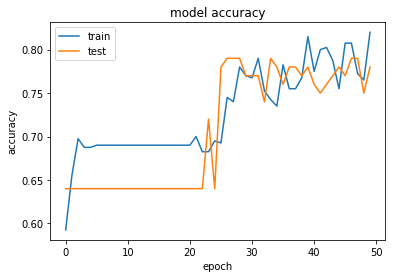

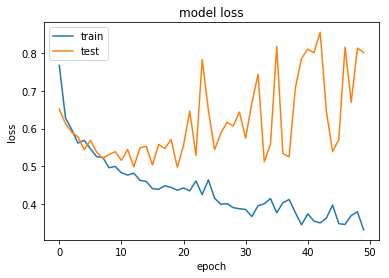

In [9]:
hist=trainProc(fname = 'ECG200', method='rp', argPow=2, epoch=50)